# 2.8 推論の実施

- 本ファイルでは、学習させたSSDで物体検出を行います。


# 学習目標

1.	SSDの推論を実装できるようになる

# 事前準備

- 学習させた重みパラメータを用意
- フォルダ「utils」のssd_predict_show.pyを使用します

In [1]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

# 推論を実行する

In [2]:
from utils.ssd_model import SSD

classes = ["inlinemf", "displaymf"]

# SSD300の設定
ssd_cfg = {
    'num_classes': 3,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)

# SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd300_50.pth',
                         map_location={'cuda:0': 'cpu'})

#net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('ネットワーク設定完了：学習済みの重みをロードしました')


ネットワーク設定完了：学習済みの重みをロードしました


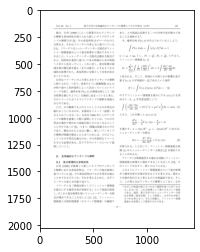

torch.Size([1, 3, 200, 5])
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.8065,  0.9735,  1.0123,  0.9921,  1.0223],
          [ 0.7708,  0.9471,  1.0118,  0.9656,  1.0220],
          [ 0.7707,  0.9733,  0.9848,  0.9922,  0.9948],
          ...,
          [ 0.6902,  0.1998,  0.2375,  0.2182,  0.2478],
          [ 0.6901,  0.9198,  0.6909,  0.9384,  0.7011],
          [ 0.6901,  0.3332,  0.4775,  0.3516,  0.4877]],

         [[ 0.1805,  0.8627,  0.6871,  1.0685,  1.3079],
          [ 0.0492, -0.1638,  0.7231,  0.3337,  1.1664],
          [ 0.0453,  0.8285,  0.6231,  1.1881,  1.0170],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 

c:\Users\kwmrs\Documents\studies\SSD_JPMath\utils\ssd_model.py:581: UserWarning: An output with one or more elements was resized since it had shape [199], which does not match the required output shape [198].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ..\aten\src\ATen\native\Resize.cpp:23.)
  torch.index_select(x1, 0, idx, out=tmp_x1)
c:\Users\kwmrs\Documents\studies\SSD_JPMath\utils\ssd_model.py:582: UserWarning: An output with one or more elements was resized since it had shape [199], which does not match the required output shape [198].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  .

In [3]:
from utils.ssd_model import DataTransform

# 1. 画像読み込み
image_file_path = "./data/JPMathDataset/train/img/000_004.png"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 4. 前処理
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # アノテーションはないので、""にする
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSDで予測
net.eval()  # ネットワークを推論モードへ
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])
#  =（batch_num、クラス、confのtop200、規格化されたBBoxの情報）
#   規格化されたBBoxの情報（確信度、xmin, ymin, xmax, ymax）


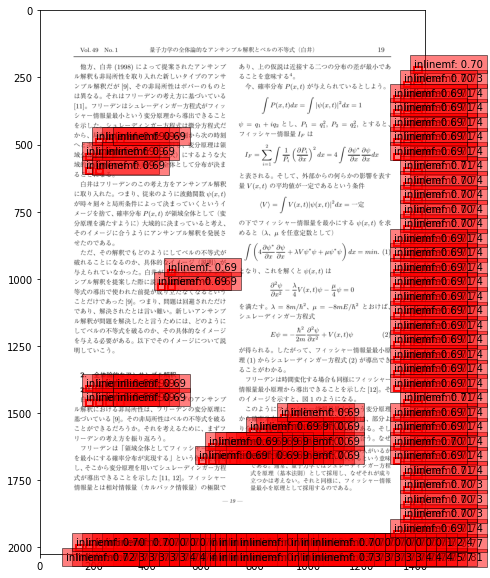

In [4]:
# 画像に対する予測
from utils.ssd_predict_show import SSDPredictShow

# ファイルパス
image_file_path = "./data/JPMathDataset/train/img/000_004.png"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)



以上